In [58]:
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertModel, DistilBertTokenizer
from sklearn import metrics
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords

import pandas as pd
import numpy as np

import sqlite3
import pandas as pd
import json

In [59]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
    x = torch.ones(1, device=device)
    print(x)
else:
    device = torch.device('cpu')
    print("MPS device not found.")

MPS device not found.


In [60]:
 
nltk.download('stopwords')
nltk_stopwords = set(stopwords.words('english'))
nltk_stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Anna\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [61]:
from io import StringIO
from html.parser import HTMLParser
from bs4 import BeautifulSoup

class MLStripper(HTMLParser):
    def __init__(self):
        super().__init__()
        self.reset()
        self.strict = False
        self.convert_charrefs= True
        self.text = StringIO()
    def handle_data(self, d):
        self.text.write(d)
    def get_data(self):
        return self.text.getvalue()

def get_latex_from_alt(context):
    strip_deliminators = lambda latex: latex.replace('$','').replace('\\[','').replace('\\]','')

    context_soup = BeautifulSoup(context)
    latex_images = context_soup.find_all('img')
    for image in latex_images:
        image.replace_with(strip_deliminators(image['alt']))
    # return [strip_deliminators(image['alt']) for image in latex_images]
    return str(context_soup)

def strip_tags(html):
    s = MLStripper()
    s.feed(html)
    return s.get_data()

def remove_stopwords(text):
    filtered_text = [w for w in text.split() if w.lower() not in nltk_stopwords]
    return " ".join(filtered_text)

In [62]:
get_latex_from_alt('<html><head></head><body><p>In the following list of numbers, the integer <img alt=\"$n$\" class=\"latex\" height=\"8\" src=\"//latex.artofproblemsolving.com/1/7/4/174fadd07fd54c9afe288e96558c92e0c1da733a.png\" width=\"10\"/> appears <img alt=\"$n$\" class=\"latex\" height=\"8\" src=\"//latex.artofproblemsolving.com/1/7/4/174fadd07fd54c9afe288e96558c92e0c1da733a.png\" width=\"10\"/> times in the list for <img alt=\"$1 \\leq n \\leq 200$\" class=\"latex\" height=\"15\" src=\"//latex.artofproblemsolving.com/9/1/7/917e3430450e9049864739d088103bef0598a899.png\" style=\"vertical-align: -2px\" width=\"95\"/>.<img alt=\"\\[1, 2, 2, 3, 3, 3, 4, 4, 4, 4, \\ldots, 200, 200, \\ldots , 200\\]\" class=\"latexcenter\" height=\"16\" src=\"//latex.artofproblemsolving.com/f/4/f/f4f50e6ad3c33b14e7352b50ecc5ff8322c37702.png\" width=\"332\"/>What is the median of the numbers in this list?\n</p><p>\n</p></body></html>')
remove_stopwords('value x satisfies x- \\frac{3}{4} = \\frac{5}{12} - \\frac{1}{3}? Adding \\frac{3}{4} sides, x= \\frac{5}{12} - \\frac{1}{3} + \\frac{3}{4} = \\frac{5}{12} - \\frac{4}{12} + \\frac{9}{12}=\\boxed{\\textbf{(E) }\\frac{5}{6}}. Multiplying 12 sides gets us 12x-9=1 \\Rightarrow 12x=10, therefore \\boxed{x=\\textbf{(E)}~\\frac{5}{6}}. \\ {-}\\frac{2}{3} \\ \\frac{7}{36} \\ \\frac{7}{12} \\ \\frac{2}{3} \\ \\frac{5}{6}')

'value x satisfies x- \\frac{3}{4} = \\frac{5}{12} - \\frac{1}{3}? Adding \\frac{3}{4} sides, x= \\frac{5}{12} - \\frac{1}{3} + \\frac{3}{4} = \\frac{5}{12} - \\frac{4}{12} + \\frac{9}{12}=\\boxed{\\textbf{(E) }\\frac{5}{6}}. Multiplying 12 sides gets us 12x-9=1 \\Rightarrow 12x=10, therefore \\boxed{x=\\textbf{(E)}~\\frac{5}{6}}. \\ {-}\\frac{2}{3} \\ \\frac{7}{36} \\ \\frac{7}{12} \\ \\frac{2}{3} \\ \\frac{5}{6}'

In [63]:
problems_data = pd.read_json("amc_12_problems_with_sol.json")
problems_data = problems_data.transpose()
years = []
instances = []
ids = []
for i in range(problems_data.shape[0]):
    ids.append(i+1)
    t = problems_data.iloc[i]["test"]
    years.append(t[0])
    instances.append(t[2])
problems_data.insert(0,"id",ids,True)
problems_data.insert(6, "year", years, True)
problems_data.insert(7, "instance", instances, True)
temp = [None]*problems_data.shape[0]
problems_data.insert(6, "labels", temp, True)
diff = [0]*problems_data.shape[0]
#figure out difficulty
problems_data.insert(7, "difficulty", diff, True)
problems_data = problems_data[['id', 'test', 'number', 'choices','problem','answer','solutions','labels','difficulty','year','instance']]
problems_data.insert(11, "trig", diff, True)
problems_data.insert(12, "cn", diff, True)
problems_data.insert(13, "log", diff, True)
problems_data

,id,test,number,choices,problem,answer,solutions,labels,difficulty,year,instance,trig,cn,log
2015 AMC 12A #2,1,"[2015, 12, A]",2,"[\ 52, \ 57, \ 62, \ 67, \ 72]",<html><head></head><body><p>Two of the three s...,E,"[<p>Letting <img alt=""$x$"" class=""latex"" heigh...",None,0,2015,A,0,0,0
2015 AMC 12A #5,2,"[2015, 12, A]",5,"[\ \text{She rounds all three numbers up.}\\ ,...",<html><head></head><body><p>Sreshtha needs to ...,D,"[<p>To maximize our estimate, we want to maxim...",None,0,2015,A,0,0,0
2015 AMC 12A #9,3,"[2015, 12, A]",9,"[\ \frac{1}{10} , \ \frac{1}{6} , \ \frac{1}{5...",<html><head></head><body><p>A box contains 2 r...,C,[<p>If Cheryl gets two marbles of the same col...,None,0,2015,A,0,0,0
2015 AMC 12A #10,4,"[2015, 12, A]",10,"[\ 8 , \ 10 , \ 15 , \ 18 , \ 26]",<html><head></head><body><p>Integers <img alt=...,E,"[<p>Use <a class=""mw-redirect"" href=""/wiki/ind...",None,0,2015,A,0,0,0
2015 AMC 12A #11,5,"[2015, 12, A]",11,"[\ 2 , \ 3 , \ 4 , \ 5, \ 6]",<html><head></head><body><p>On a sheet of pape...,D,"[<p>Isabella can get <img alt=""$0$"" class=""lat...",None,0,2015,A,0,0,0
2015 AMC 12A #12,6,"[2015, 12, A]",12,"[\ 1, \ 1.5, \ 2, \ 2.5, \ 3]",<html><head></head><body><p>The parabolas <img...,B,"[<p>Clearly, the parabolas must intersect the ...",None,0,2015,A,0,0,0
2015 AMC 12A #13,7,"[2015, 12, A]",13,[\ \text{There must be an even number of odd s...,<html><head></head><body><p>A league with 12 t...,E,[<p>\nWe can eliminate answer choices <img alt...,None,0,2015,A,0,0,0
2015 AMC 12A #14,8,"[2015, 12, A]",14,"[\ 9, \ 12, \ 18, \ 24, \ 36]",<html><head></head><body><p>What is the value ...,D,[<p>We use the change of base formula to show ...,None,0,2015,A,0,0,0
2015 AMC 12A #15,9,"[2015, 12, A]",15,"[\ 4, \ 22, \ 26, \ 30, \ 104]",<html><head></head><body><p>What is the minimu...,C,"[<p>We can rewrite the fraction as <img alt=""$...",None,0,2015,A,0,0,0
2015 AMC 12A #18,10,"[2015, 12, A]",18,"[\ 7 , \ 8 , \ 16 , \ 17 , \ 18]",<html><head></head><body><p>The zeros of the f...,C,[<p>The problem asks us to find the sum of eve...,None,0,2015,A,0,0,0


In [64]:
# problems_data['test'] = problems_data['test'].apply(json.loads)
problems_data['solutions'] = problems_data['solutions'].apply(lambda x: " ".join([solution for solution in x 
                                                                                    if 'http' not in solution]))
problems_data['year'] = problems_data['test'].apply(lambda x: str(x[0]))
problems_data['instance'] = problems_data['test'].apply(lambda x: x[2])

# problems_data.head(5)

In [65]:
problems_data['year'].unique()

array(['2015', '2016', '2017', '2018', '2019', '2020', '2021',
       '2021_Fall', '2022', '2023'], dtype=object)

In [66]:
labeled_data = pd.read_csv('problem_labels_12.csv')
labeled_data.shape

(60, 4)

In [67]:
labeled_data

,Problem,Trig,Complex Numbers,Logarithms
0,2023A #25,1,0,0
1,2023A #15,1,0,0
2,2023B #17,1,0,0
3,2023B #20,1,0,0
4,2022B #14,1,0,0
5,2022B #19,1,0,0
6,2022A #12,1,0,0
7,2022A #17,1,0,0
8,2021B Fall #8,1,0,0
9,2021B Fall #10,1,0,0


In [68]:
for i in range(60):
    t = labeled_data.iloc[i]["Problem"]
    year = t[:4]
    instance = t[4:5]
    if len(t)>9:
        year+="_Fall"
        number = t[12:]
    else:
        number = t[7:]
    print(year)
    print(instance)
    print(number)
    index = problems_data.index[(problems_data['year'] == year)&(problems_data['instance'] == instance)&(problems_data['number'] == int(number))].tolist()[0]
    print(index)
    # print(problems_data.loc(index))
    if labeled_data.iloc[i]["Trig"]==1:
        problems_data.at[index, "trig"] = 1
    if labeled_data.iloc[i]["Complex Numbers"]==1:
        problems_data.at[index, "cn"] = 1
    if labeled_data.iloc[i]["Logarithms"]==1:
        problems_data.at[index, "log"] = 1
        


2023
A
25
2023 AMC 12A #25
2023
A
15
2023 AMC 12A #15
2023
B
17
2023 AMC 12B #17
2023
B
20
2023 AMC 12B #20
2022
B
14
2022 AMC 12B #14
2022
B
19
2022 AMC 12B #19
2022
A
12
2022 AMC 12A #12
2022
A
17
2022 AMC 12A #17
2021_Fall
B
8
2021_Fall AMC 12B #8
2021_Fall
B
10
2021_Fall AMC 12B #10
2021_Fall
B
13
2021_Fall AMC 12B #13
2021_Fall
B
24
2021_Fall AMC 12B #24
2021_Fall
A
19
2021_Fall AMC 12A #19
2021
B
13
2021 AMC 12B #13
2021
A
19
2021 AMC 12A #19
2021
A
22
2021 AMC 12A #22
2020
B
25
2020 AMC 12B #25
2020
A
9
2020 AMC 12A #9
2019
B
12
2019 AMC 12B #12
2019
A
19
2019 AMC 12A #19
2023
A
14
2023 AMC 12A #14
2023
A
16
2023 AMC 12A #16
2023
B
12
2023 AMC 12B #12
2022
B
11
2022 AMC 12B #11
2022
A
13
2022 AMC 12A #13
2022
A
22
2022 AMC 12A #22
2021_Fall
B
21
2021_Fall AMC 12B #21
2021_Fall
A
15
2021_Fall AMC 12A #15
2021
B
18
2021 AMC 12B #18
2021
A
13
2021 AMC 12A #13
2021
A
21
2021 AMC 12A #21
2020
B
17
2020 AMC 12B #17
2020
B
23
2020 AMC 12B #23
2020
A
15
2020 AMC 12A #15
2020
A
22
2020 A

In [69]:
for i in range(problems_data.shape[0]-30,-1,-1):
    index = problems_data.iloc[i].name
    if problems_data.at[index, "trig"]!=1 and problems_data.at[index, "cn"]!=1 and problems_data.at[index, "log"]!=1:
        problems_data = problems_data.drop(problems_data.iloc[i].name)
        print(index)
        i-=1
problems_data
print(problems_data.shape)

2022 AMC 12B #24
2022 AMC 12B #17
2022 AMC 12B #12
2022 AMC 12B #10
2022 AMC 12B #9
2022 AMC 12B #8
2022 AMC 12B #5
2022 AMC 12A #25
2022 AMC 12A #23
2022 AMC 12A #21
2022 AMC 12A #16
2022 AMC 12A #8
2022 AMC 12A #5
2022 AMC 12A #3
2022 AMC 12A #2
2021_Fall AMC 12B #25
2021_Fall AMC 12B #23
2021_Fall AMC 12B #22
2021_Fall AMC 12B #18
2021_Fall AMC 12B #17
2021_Fall AMC 12B #16
2021_Fall AMC 12B #15
2021_Fall AMC 12B #14
2021_Fall AMC 12B #12
2021_Fall AMC 12B #9
2021_Fall AMC 12A #25
2021_Fall AMC 12A #24
2021_Fall AMC 12A #22
2021_Fall AMC 12A #21
2021_Fall AMC 12A #16
2021_Fall AMC 12A #14
2021_Fall AMC 12A #13
2021_Fall AMC 12A #12
2021_Fall AMC 12A #11
2021_Fall AMC 12A #8
2021 AMC 12B #24
2021 AMC 12B #23
2021 AMC 12B #21
2021 AMC 12B #20
2021 AMC 12B #19
2021 AMC 12B #17
2021 AMC 12B #16
2021 AMC 12B #14
2021 AMC 12B #11
2021 AMC 12B #10
2021 AMC 12B #3
2021 AMC 12A #25
2021 AMC 12A #24
2021 AMC 12A #20
2021 AMC 12A #15
2021 AMC 12A #11
2021 AMC 12A #8
2021 AMC 12A #6
2021 AMC 12

In [70]:
problems_data['tl-labels'] = problems_data[['trig','cn','log']].values.tolist()
# problems_data = problems_data[['year','instance','number','choices','problem','solutions']]
problems_data['problem'] = problems_data['problem'].map(lambda x: strip_tags(get_latex_from_alt(x)))
problems_data['solutions'] = problems_data['solutions'].map(lambda x: strip_tags(get_latex_from_alt(x)))
problems_data['choices'] = problems_data['choices'].map(lambda x: ' '.join(x))
problems_data['context'] = problems_data['problem'] + problems_data['choices'] 
problems_data['context'] = problems_data['context'].map(remove_stopwords)
problems_data

,id,test,number,choices,problem,answer,solutions,labels,difficulty,year,instance,trig,cn,log,tl-labels,context
2015 AMC 12A #14,8,"[2015, 12, A]",14,\ 9 \ 12 \ 18 \ 24 \ 36,What is the value of a for which \frac{1}{\tex...,D,We use the change of base formula to show that...,None,0,2015,A,0,0,1,"[0, 0, 1]",value \frac{1}{\text{log}_2a} + \frac{1}{\text...
2016 AMC 12A #16,55,"[2016, 12, A]",16,\ 2 \ 3 \ 4 \ 5 \ 6,"The graphs of y=\log_3 x, y=\log_x 3, y=\log_\...",D,Setting the first two equations equal to each ...,None,0,2016,A,0,0,1,"[0, 0, 1]","graphs y=\log_3 x, y=\log_x 3, y=\log_\frac{1}..."
2017 AMC 12A #20,107,"[2017, 12, A]",20,\ 198 \ 199 \ 398 \ 399 \ 597,"How many ordered pairs (a,b) such that a is a ...",E,"By the properties of logarithms, we can rearra...",None,0,2017,A,0,0,1,"[0, 0, 1]","many ordered pairs (a,b) positive real number ..."
2018 AMC 12A #14,142,"[2018, 12, A]",14,5 13 17 31 35,The solutions to the equation \log_{3x} 4 = \l...,D,"We apply the Change of Base Formula, then rear...",None,0,2018,A,0,0,1,"[0, 0, 1]","solutions equation \log_{3x} 4 = \log_{2x} 8, ..."
2018 AMC 12B #7,153,"[2018, 12, B]",7,3 3\log_{7}23 6 9 10,What is the value of \log_37\cdot\log_59\cdot\...,C,"From the Change of Base Formula, we have \frac...",None,0,2018,B,0,0,1,"[0, 0, 1]",value \log_37\cdot\log_59\cdot\log_711\cdot\lo...
2018 AMC 12B #16,158,"[2018, 12, B]",16,\frac{1}{6}\sqrt{6} \frac{3}{2}\sqrt{2}-\f...,The solutions to the equation (z+6)^8=81 are c...,B,Recall that translations preserve the shapes a...,None,0,2018,B,0,1,0,"[0, 1, 0]",solutions equation (z+6)^8=81 connected comple...
2019 AMC 12A #12,166,"[2019, 12, A]",12,\frac{25}{2} 20 \frac{45}{2} 25 32,Positive real numbers x \neq 1 and y \neq 1 sa...,B,"Let \log_2{x} = \log_y{16}=k, so that 2^k=x an...",None,0,2019,A,0,0,1,"[0, 0, 1]",Positive real numbers x \neq 1 \neq 1 satisfy ...
2019 AMC 12A #14,168,"[2019, 12, A]",14,2 \sqrt{6} 2\sqrt{2} 3 \sqrt{10},"For a certain complex number c, the polynomial...",E,The polynomial can be factored further broken ...,None,0,2019,A,0,1,0,"[0, 1, 0]","certain complex number c, polynomial P(x) = (x..."
2019 AMC 12A #15,169,"[2019, 12, A]",15,10^{52} 10^{100} 10...,Positive real numbers a and b have the propert...,D,"Since \sqrt{\log{a}} is a positive integer, we...",None,0,2019,A,0,0,1,"[0, 0, 1]",Positive real numbers b property \sqrt{\log{a}...
2019 AMC 12A #19,171,"[2019, 12, A]",19,9 12 23 27 44,"In \triangle ABC with integer side lengths, \c...",A,"Notice that by the Law of Sines, a:b:c = \sin{...",None,0,2019,A,1,0,0,"[1, 0, 0]","\triangle ABC integer side lengths, \cos = \fr..."


In [71]:
pd.options.display.max_rows = 4000
problems_data

,id,test,number,choices,problem,answer,solutions,labels,difficulty,year,instance,trig,cn,log,tl-labels,context
2015 AMC 12A #14,8,"[2015, 12, A]",14,\ 9 \ 12 \ 18 \ 24 \ 36,What is the value of a for which \frac{1}{\tex...,D,We use the change of base formula to show that...,None,0,2015,A,0,0,1,"[0, 0, 1]",value \frac{1}{\text{log}_2a} + \frac{1}{\text...
2016 AMC 12A #16,55,"[2016, 12, A]",16,\ 2 \ 3 \ 4 \ 5 \ 6,"The graphs of y=\log_3 x, y=\log_x 3, y=\log_\...",D,Setting the first two equations equal to each ...,None,0,2016,A,0,0,1,"[0, 0, 1]","graphs y=\log_3 x, y=\log_x 3, y=\log_\frac{1}..."
2017 AMC 12A #20,107,"[2017, 12, A]",20,\ 198 \ 199 \ 398 \ 399 \ 597,"How many ordered pairs (a,b) such that a is a ...",E,"By the properties of logarithms, we can rearra...",None,0,2017,A,0,0,1,"[0, 0, 1]","many ordered pairs (a,b) positive real number ..."
2018 AMC 12A #14,142,"[2018, 12, A]",14,5 13 17 31 35,The solutions to the equation \log_{3x} 4 = \l...,D,"We apply the Change of Base Formula, then rear...",None,0,2018,A,0,0,1,"[0, 0, 1]","solutions equation \log_{3x} 4 = \log_{2x} 8, ..."
2018 AMC 12B #7,153,"[2018, 12, B]",7,3 3\log_{7}23 6 9 10,What is the value of \log_37\cdot\log_59\cdot\...,C,"From the Change of Base Formula, we have \frac...",None,0,2018,B,0,0,1,"[0, 0, 1]",value \log_37\cdot\log_59\cdot\log_711\cdot\lo...
2018 AMC 12B #16,158,"[2018, 12, B]",16,\frac{1}{6}\sqrt{6} \frac{3}{2}\sqrt{2}-\f...,The solutions to the equation (z+6)^8=81 are c...,B,Recall that translations preserve the shapes a...,None,0,2018,B,0,1,0,"[0, 1, 0]",solutions equation (z+6)^8=81 connected comple...
2019 AMC 12A #12,166,"[2019, 12, A]",12,\frac{25}{2} 20 \frac{45}{2} 25 32,Positive real numbers x \neq 1 and y \neq 1 sa...,B,"Let \log_2{x} = \log_y{16}=k, so that 2^k=x an...",None,0,2019,A,0,0,1,"[0, 0, 1]",Positive real numbers x \neq 1 \neq 1 satisfy ...
2019 AMC 12A #14,168,"[2019, 12, A]",14,2 \sqrt{6} 2\sqrt{2} 3 \sqrt{10},"For a certain complex number c, the polynomial...",E,The polynomial can be factored further broken ...,None,0,2019,A,0,1,0,"[0, 1, 0]","certain complex number c, polynomial P(x) = (x..."
2019 AMC 12A #15,169,"[2019, 12, A]",15,10^{52} 10^{100} 10...,Positive real numbers a and b have the propert...,D,"Since \sqrt{\log{a}} is a positive integer, we...",None,0,2019,A,0,0,1,"[0, 0, 1]",Positive real numbers b property \sqrt{\log{a}...
2019 AMC 12A #19,171,"[2019, 12, A]",19,9 12 23 27 44,"In \triangle ABC with integer side lengths, \c...",A,"Notice that by the Law of Sines, a:b:c = \sin{...",None,0,2019,A,1,0,0,"[1, 0, 0]","\triangle ABC integer side lengths, \cos = \fr..."


In [72]:
MAX_LEN = 256
TRAIN_BATCH_SIZE = 6
VALID_BATCH_SIZE = 4
EPOCHS = 50
LEARNING_RATE = 1e-05

In [73]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased',truncation_side='left',truncation=True)
tokenizer.add_tokens(list(open('latex-vocabulary/latex_symbols.txt','r')))

13855

In [74]:
class MultiLabelDataset(Dataset):
    def __init__(self, dataframe, tokenizer, labels, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe['context']
        self.targets = dataframe[labels]
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']

        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [75]:
train_size = 0.8
training_data = problems_data.sample(frac=train_size, random_state=200)
validation_data = problems_data.drop(training_data.index).reset_index(drop=True)
training_data = training_data.reset_index(drop=True)
print(validation_data)

     id           test number  \
0    55  [2016, 12, A]     16   
1   166  [2019, 12, A]     12   
2   168  [2019, 12, A]     14   
3   171  [2019, 12, A]     19   
4   178  [2019, 12, B]      9   
5   186  [2019, 12, B]     24   
6   192  [2020, 12, A]     10   
7   223  [2021, 12, A]     19   
8   225  [2021, 12, A]     21   
9   277  [2022, 12, A]     13   
10  297  [2023, 12, A]      6   
11  301  [2023, 12, A]     14   
12  302  [2023, 12, A]     15   
13  303  [2023, 12, A]     16   
14  314  [2023, 12, B]     12   
15  321  [2023, 12, B]     22   

                                              choices  \
0                                 \ 2 \ 3 \ 4 \ 5 \ 6   
1          \frac{25}{2}   20   \frac{45}{2}   25   32   
2        2    \sqrt{6}    2\sqrt{2}    3    \sqrt{10}   
3                           9    12    23    27    44   
4                              57   59   61   62   63   
5    \frac{1}{2}\sqrt3   \frac{3}{4}\sqrt3   \frac...   
6                             4    7   

In [76]:
training_dataset = MultiLabelDataset(training_data, tokenizer, 'tl-labels', MAX_LEN)
val_dataset = MultiLabelDataset(validation_data, tokenizer, 'tl-labels', MAX_LEN)

In [77]:
train_params = {'batch_size': TRAIN_BATCH_SIZE,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': VALID_BATCH_SIZE,
                'shuffle': False,
                'num_workers': 0
                }

training_loader = DataLoader(training_dataset, **train_params)
testing_loader = DataLoader(val_dataset, **test_params)

In [78]:
class DistilBERTClass(torch.nn.Module):
    def __init__(self, num_classes):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.3)
        self.classifier = torch.nn.Linear(768, num_classes)

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        return self.classifier(pooler)

In [79]:
top_level_model = DistilBERTClass(num_classes=3)
top_level_model.to(device)

DistilBERTClass(
  (l1): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1): Linear(in

In [80]:
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [81]:
optimizer = torch.optim.Adam(params =  top_level_model.parameters(), lr=LEARNING_RATE)

In [82]:
class ModelTraining:
    def __init__(self, model, training_loader, testing_loader, optimizer):
        self.model = model
        self.training_loader = training_loader
        self.optimizer = optimizer
        self.testing_loader = testing_loader
    
    def train_model(self,epoch):
        self.model.train()
        for _, data in enumerate(self.training_loader):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            
            outputs = self.model(ids, mask)

            self.optimizer.zero_grad()
            loss = loss_fn(outputs, targets)
            if _%1000==0:
                print(f'Epoch: {epoch}, Loss: {loss.item()}')
            
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
    
    def validation(self):
        self.model.eval()
        fin_targets=[]
        fin_outputs=[]
        with torch.no_grad():
            for _, data in enumerate(self.testing_loader):
                ids = data['ids'].to(device, dtype = torch.long)
                mask = data['mask'].to(device, dtype = torch.long)
                # token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
                targets = data['targets'].to(device, dtype = torch.float)
                outputs = self.model(ids, mask)
                fin_targets.extend(targets.cpu().detach().numpy().tolist())
                fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
        return fin_outputs, fin_targets

In [83]:
tl_model_trainer = ModelTraining(top_level_model,training_loader,testing_loader,optimizer)
for epoch in range(EPOCHS):
    tl_model_trainer.train_model(epoch)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\Anna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Epoch: 0, Loss: 0.6942672729492188
Epoch: 1, Loss: 0.6298795342445374
Epoch: 2, Loss: 0.5324697494506836
Epoch: 3, Loss: 0.49630171060562134
Epoch: 4, Loss: 0.42124801874160767
Epoch: 5, Loss: 0.48248767852783203
Epoch: 6, Loss: 0.45484256744384766
Epoch: 7, Loss: 0.42710956931114197
Epoch: 8, Loss: 0.44416365027427673
Epoch: 9, Loss: 0.38511690497398376
Epoch: 10, Loss: 0.2997743785381317
Epoch: 11, Loss: 0.2603059709072113
Epoch: 12, Loss: 0.2752498388290405
Epoch: 13, Loss: 0.25970709323883057
Epoch: 14, Loss: 0.2125677615404129
Epoch: 15, Loss: 0.20216163992881775
Epoch: 16, Loss: 0.18068605661392212
Epoch: 17, Loss: 0.13151627779006958
Epoch: 18, Loss: 0.13684973120689392
Epoch: 19, Loss: 0.1260516345500946
Epoch: 20, Loss: 0.10796840488910675
Epoch: 21, Loss: 0.09546153247356415
Epoch: 22, Loss: 0.09714396297931671
Epoch: 23, Loss: 0.07516451925039291
Epoch: 24, Loss: 0.0867396891117096
Epoch: 25, Loss: 0.0768994390964508
Epoch: 26, Loss: 0.08583793044090271
Epoch: 27, Loss: 0.07

In [84]:
torch.save(top_level_model,'top-level-with-solutions-distilbert-amc12-2019-2022.pt')

In [85]:
model = torch.load('top-level-with-solutions-distilbert-amc12-2019-2022.pt')

In [86]:
# def validation(testing_loader):
#     model.eval()
#     fin_targets=[]
#     fin_outputs=[]
#     with torch.no_grad():
#         for _, data in enumerate(testing_loader):
#             ids = data['ids'].to(device, dtype = torch.long)
#             mask = data['mask'].to(device, dtype = torch.long)
#             # token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
#             targets = data['targets'].to(device, dtype = torch.float)
#             outputs = top_level_model(ids, mask)
#             fin_targets.extend(targets.cpu().detach().numpy().tolist())
#             fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
#     return fin_outputs, fin_targets

[[False False  True]
 [False False  True]
 [False  True False]
 [ True False False]
 [False False  True]
 [False  True False]
 [False False  True]
 [ True False False]
 [False  True False]
 [False False False]
 [False False  True]
 [False  True False]
 [False False False]
 [False False False]
 [False  True False]
 [False  True False]]
Accuracy Score = 0.75
F1 Score (Micro) = 0.8571428571428571
F1 Score (Macro) = 0.8564102564102565
[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0], [0.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0]]
[[0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 1.0, 0.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0]]


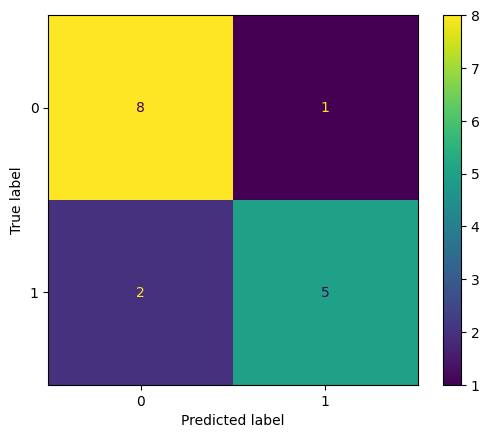

In [87]:
from itertools import chain

tl_model_trainer = ModelTraining(top_level_model,training_loader,testing_loader,optimizer)

outputs, targets = tl_model_trainer.validation()

outputs = np.array(outputs) >= 0.5
print(outputs)
outputs = [[1.0 if value else 0.0 for value in output] for output in outputs]

outputs1 = [output[1] for output in outputs]
targets1 = [target[1] for target in targets]

# cm = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(list(chain.from_iterable(targets)),
                                                            #  list(chain.from_iterable(outputs))))
cm = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(targets1, outputs1))
cm.plot()

accuracy = metrics.accuracy_score(targets, outputs)
f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

print(outputs)
print(targets)

In [ ]:
# for cm in metrics.multilabel_confusion_matrix(targets,outputs):
#     matrix = metrics.ConfusionMatrixDisplay(cm)
#     matrix.plot()
# single_label_accuracy = metrics.accuracy_score(list(chain.from_iterable(targets)), list(chain.from_iterable(outputs)))
# print(f"Single-label Accuracy Score = {single_label_accuracy}")

C:\Users\Anna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\transformers\tokenization_utils_base.py:2674: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


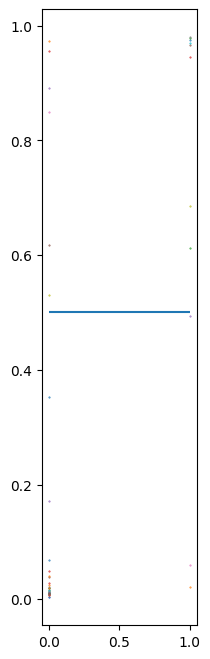

In [256]:
outputs, targets = tl_model_trainer.validation()

plt.figure(figsize=(2,8))
for i in range(len(targets)):
    plt.scatter(targets[i],outputs[i],s=.2)
plt.hlines(.5,0,1)
plt.show()

In [ ]:
def generate_model(dataframe, labels):
    training_data = dataframe.sample(frac=train_size, random_state=200).reset_index(drop=True)
    validation_data = dataframe.drop(training_data.index).reset_index(drop=True)

    training_dataset = MultiLabelDataset(training_data, tokenizer, labels, MAX_LEN)
    val_dataset = MultiLabelDataset(validation_data, tokenizer, labels, MAX_LEN)

    training_loader = DataLoader(training_dataset, **train_params)
    testing_loader = DataLoader(val_dataset, **test_params)

    model = DistilBERTClass(len(dataframe[labels].iloc[0]))
    model.to(device)

    return model, training_loader, testing_loader

In [ ]:
alg_data = problems_data.loc[problems_data['Algebra'] == True]
alg_data = alg_data[['year','instance','number','context','alg-labels']].reset_index()
alg_data

In [ ]:
alg_model, alg_training_loader, alg_testing_loader = generate_model(alg_data, 'alg-labels')
alg_optimizer = torch.optim.Adam(params=alg_model.parameters(), lr=LEARNING_RATE)
alg_model_trainer = ModelTraining(alg_model, alg_training_loader, alg_testing_loader, alg_optimizer)

In [ ]:
for epoch in range(EPOCHS):
    alg_model_trainer.train_model(epoch)

In [ ]:
torch.save(alg_model,'algebra-model-distilbert-amc10-2019-2022.pt')

In [ ]:
outputs, targets = alg_model_trainer.validation()



plt.figure(figsize=(2,8))
for i in range(len(targets)):
    plt.scatter(targets[i],outputs[i],s=.2)
plt.hlines(.5,0,1)
plt.show()

outputs = np.array(outputs) >= 0.5
outputs = [[1 if value else 0 for value in output] for output in outputs]

targets = list(chain.from_iterable(targets))
outputs = list(chain.from_iterable(outputs))

cm = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(targets,outputs))
cm.plot()

accuracy = metrics.accuracy_score(targets, outputs)
recall = metrics.recall_score(targets, outputs)

print(f"Accuracy Score = {accuracy}")
print(f"Recall = {recall}")

In [ ]:
geo_data = problems_data.loc[problems_data['Geometry'] == True]
geo_data = geo_data[['year','instance','number','context','geo-labels']].reset_index()
geo_data

In [ ]:
geo_model, geo_training_loader, geo_testing_loader = generate_model(geo_data, 'geo-labels')
geo_optimizer = torch.optim.Adam(params=geo_model.parameters(), lr=LEARNING_RATE)
geo_model_trainer = ModelTraining(geo_model, geo_training_loader, geo_testing_loader, geo_optimizer)

In [ ]:
for epoch in range(EPOCHS):
    geo_model_trainer.train_model(epoch)

In [ ]:
torch.save(top_level_model,'geometry-model-distilbert-amc10-2019-2022.pt')

In [8]:
model = torch.load('top-level-with-solutions-distilbert-amc12-2019-2022.pt')

AttributeError: Can't get attribute 'DistilBERTClass' on <module '__main__'>

In [ ]:
outputs, targets = geo_model_trainer.validation()

plt.figure(figsize=(2,8))
for i in range(len(targets)):
    plt.scatter(targets[i],outputs[i],s=.2)
plt.hlines(.5,0,1)
plt.show()

outputs = np.array(outputs) >= 0.5
outputs = [[1 if value else 0 for value in output] for output in outputs]

targets = list(chain.from_iterable(targets))
outputs = list(chain.from_iterable(outputs))

cm = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(targets,outputs))
cm.plot()

accuracy = metrics.accuracy_score(targets, outputs)
recall = metrics.recall_score(targets, outputs)

print(f"Accuracy Score = {accuracy}")
print(f"Recall = {recall}")

In [ ]:
outputs, targets = geo_model_trainer.validation()

plt.figure(figsize=(2,8))
for i in range(len(targets)):
    plt.scatter(targets[i],outputs[i],s=.2)
plt.hlines(.5,0,1)
plt.show()